# MLB - Can you predict top 10 lowest ERA pitchers?

# Introduction

In this tutorial I will take you through some basic steps to process baseball statistics.  
Which includes tasks like importing libraries, collecting data, cleaning up the data and drawing graphs.  
Statistics is very important in the world of baseball, for example "Moneyball" the book and film which were made based off of how well the Oakland A's did with an extremely low budget because the manager assembled a team based on statistical values of the players.  
  
This is also very true for Fanyasy Baseball players such as myself. It's important to study players' past perfomences and predict who will continue to perform well and who to avoid when you are drafting.  
  
Major Leauge Baseball is constantly looking for new technologies to track different types of statistical values.  
In the year 2008, MLB started to implimented a tool called "Statcast", Statcast is a high-speed, high-accuracy, automated tool developed to analyze player movements and athletic abilities.  
This tracks information like, pitch speed, types of pitch, rotation speed, hitting average against individual pitchers, catch probablility and hundres more.  
  
The goal for this tutorial is to look at top 10 pitchers with the lowrst ERA from year 2010 to 2015 and study the following stats:  
* Pitch Velocity
* Pitch percentage inside the zone
* Pitches percentage outside the zone
* Fastball thrown percentage
* Offspeed thrown percentage
* Strikeouts per 9 innings (K/9) 

and see if we can use these values to predict the top 10 pitchers with the lowest ERA in 2016.

# Tutorial content

In this tutorial, we will use dataset provided by <a href='http://www.seanlahman.com/baseball-archive/statistics/'>Sean Lahman</a>. Sean's dataset provides detailed information from team franchises to individual player performences. Today we will be using ERA, Strikeouts and Innings pitched from his dataset.  
  
We will also use another dataset from <a = href="https://baseballsavant.mlb.com/statcast_search">Baseball Savant</a>. This website allows you to look up statistics collected by MLB's statcast tool. We will collect the stats mentioned in the introduction form this website.  
  
**Table Content**  
  

# Imports

For this tutorial we will use the following libraries to help us with our prediction.  
You will also need several csv files and asqlite file, which you can get from the links below.  


In [679]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import numpy as np

# Loading Data

In [669]:
lahman_2016 = 'lahman2016.sqlite'
conn = sqlite3.connect(lahman_2016)

pitcher_query = """SELECT (MASTER.nameFirst||\" \"||MASTER.nameLast) AS player_name,ERA, yearID AS year,
                (9*(SO/(IPOuts/3.0))) AS K9
                   FROM Pitching, MASTER
                   WHERE Pitching.playerID == MASTER.playerID AND Pitching.GS >= 20 AND
                         Pitching.yearID >=2010
                   ORDER BY yearID, ERA"""

pitcher_stats = pd.read_sql(pitcher_query, conn)
pitcher_stats.ix[pitcher_stats['player_name'] == 'R. A. Dickey', ['player_name']] = ['R.A. Dickey']
pitcher_stats.head()

,player_name,ERA,year,K9
0,Felix Hernandez,2.27,2010,8.363151
1,Josh Johnson,2.30,2010,9.114338
2,Clay Buchholz,2.33,2010,6.218810
3,Adam Wainwright,2.42,2010,8.322721
4,Roy Halladay,2.44,2010,7.863032


In [670]:
def top10(year):
    sub_df = pitcher_stats.loc[pitcher_stats['year'] == year].head(10)
    return sub_df

def clean_df(filename, columns, rename_target, rename_value):
    read = pd.read_csv(filename+".csv")
    temp = read[columns].rename(columns={rename_target : rename_value})
    return temp
top10_2010 = top10(2010)
top10_2011 = top10(2011)
top10_2012 = top10(2012)
top10_2013 = top10(2013)
top10_2014 = top10(2014)
top10_2015 = top10(2015)

top10s = top10_2010.append([top10_2011,top10_2012,top10_2013,top10_2014,top10_2015])

In [671]:
statcast_velocity = clean_df('statcast_velocity',['player_name','year','velocity'],'','')
statcast_inzone = clean_df('statcast_inzone',['player_name','year','pitch_percent'],'pitch_percent', 'inzone')
statcast_outzone = clean_df('statcast_outzone',['player_name','year','pitch_percent'],'pitch_percent', 'outzone')
statcast_fastball = clean_df('statcast_fastball',['player_name','year','pitch_percent'],'pitch_percent', 'fastball')
statcast_offspeed = clean_df('statcast_offspeed',['player_name','year','pitch_percent'],'pitch_percent', 'offspeed')

statcast = (statcast_velocity.merge(statcast_inzone,on=['player_name','year'])
                             .merge(statcast_outzone,on=['player_name','year'])
                             .merge(statcast_fastball,on=['player_name','year'])
                             .merge(statcast_offspeed,on=['player_name','year'])
                             .merge(top10s,on=['player_name','year']))
statcast.head()

,player_name,year,velocity,inzone,outzone,fastball,offspeed,ERA,K9
0,Matt Harvey,2015,93.2,51.82,48.18,60.76,38.88,2.71,8.936620
1,Gerrit Cole,2015,93.0,50.32,49.68,66.90,32.91,2.60,8.740385
2,Matt Harvey,2013,92.7,52.65,47.31,56.77,43.05,2.27,9.639252
3,Josh Johnson,2010,92.7,48.69,51.14,61.78,37.68,2.30,9.114338
4,Ubaldo Jimenez,2010,92.3,47.89,50.86,76.33,21.78,2.88,8.688722


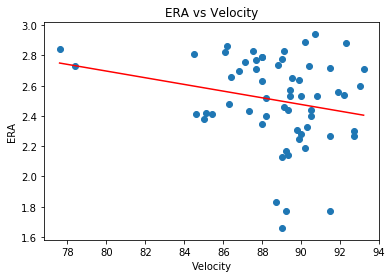

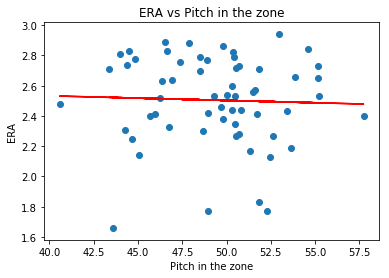

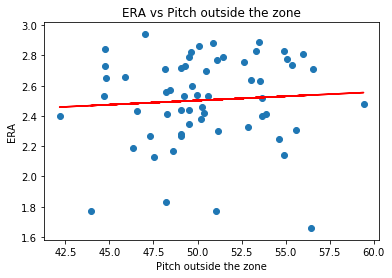

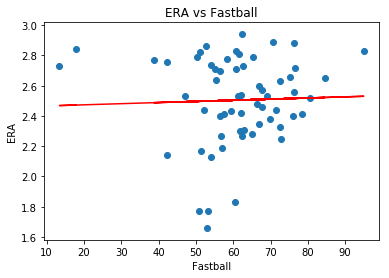

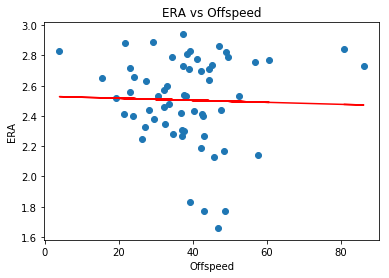

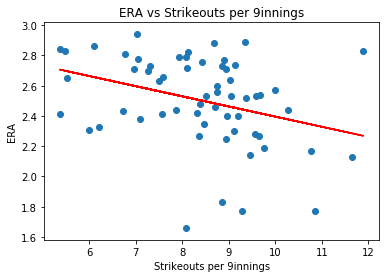

In [672]:
columns = {'velocity':2, 'inzone':3, 'outzone':4, 'fastball':5, 'offspeed':6, 'ERA':7, 'K9':8}
titles = ['Velocity','Pitch in the zone','Pitch outside the zone','Fastball','Offspeed','Strikeouts per 9innings']

%matplotlib inline

def reg_line(df, x, y):
    npMatrix = np.matrix(df)
    X, Y = npMatrix[:,columns[x]], npMatrix[:,columns[y]]
    model = linear_model.LinearRegression().fit(X,Y)
    m = model.coef_[0]
    b = model.intercept_
    return m,b

v_m, v_b =  reg_line(statcast, 'velocity', 'ERA')
in_m, in_b =  reg_line(statcast, 'inzone', 'ERA')
out_m, out_b =  reg_line(statcast, 'outzone', 'ERA')
fast_m, fast_b =  reg_line(statcast, 'fastball', 'ERA')
off_m, off_b =  reg_line(statcast, 'offspeed', 'ERA')
k9_m, k9_b =  reg_line(statcast, 'K9', 'ERA')

X = [statcast['velocity'],statcast['inzone'],statcast['outzone'],
     statcast['fastball'],statcast['offspeed'],statcast['K9']]
Y = [statcast['ERA'],statcast['ERA'],statcast['ERA'],statcast['ERA'],statcast['ERA'],statcast['ERA']]
reg = [[v_m,v_b],[in_m,in_b],[out_m,out_b],[fast_m,fast_b],[off_m,off_b],[k9_m,k9_b]]

plots = zip(X,Y)
def loop_plot(plots):
    figs={}
    axs={}
    for idx,plot in enumerate(plots):
        figs[idx]=plt.figure()
        axs[idx]=figs[idx].add_subplot(111)
        axs[idx].scatter(plot[0],plot[1])
        axs[idx].plot(plot[0], plot[0]*reg[idx][0]+reg[idx][1], color="red")
        plt.title('ERA vs ' + titles[idx])
        plt.xlabel(titles[idx])
        plt.ylabel('ERA')
    plt.show()

loop_plot(plots)

In [673]:
velocity = str(round((((2.5-v_b)/(v_m))[0]),2))
outzone = str(round((((2.5-out_b)/(out_m))[0]),2))
offspeed = str(round((((2.5-off_b)/(off_m))[0]),2))
k9 = str(round((((2.5-k9_b)/(k9_m))[0]),2))

print ("pitch velocity > " + velocity + " MPH")
print ("pitches outside the zone < " + outzone + "%")
print ("offspeed pitch usage > " + offspeed + "%")
print ("Strikeouts per 9innings > " + k9)



pitch velocity > 88.91 MPH
pitches outside the zone < 49.58%
offspeed pitch usage > 45.43%
Strikeouts per 9innings > 8.44


In [678]:
temp = (statcast_velocity.merge(statcast_inzone,on=['player_name','year'])
                             .merge(statcast_outzone,on=['player_name','year'])
                             .merge(statcast_fastball,on=['player_name','year'])
                             .merge(statcast_offspeed,on=['player_name','year'])
                             .merge(pitcher_stats,on=['player_name','year']))

new = temp
new = new.loc[new['velocity'] >= float(velocity)]
new = new.loc[new['K9'] >= float(k9)]
new = new.loc[new['outzone'] <= float(outzone)]
new = new.loc[new['offspeed'] >= float(offspeed)]
new

,player_name,year,velocity,inzone,outzone,fastball,offspeed,ERA,K9
28,Corey Kluber,2014,90.5,50.80,49.09,52.20,47.46,2.44,10.272984
39,Corey Kluber,2015,90.2,50.61,49.39,52.35,47.31,3.49,9.932432
75,Chris Sale,2014,89.2,51.33,48.60,51.40,48.42,2.17,10.758621
82,Clayton Kershaw,2015,89.0,52.46,47.54,53.99,45.78,2.13,11.643266


In [675]:
statcast['velocity'].mean()

88.69666666666669